## Lesson-07 Recurrent Neural Networks 循环神经网络的原理及应用

循环神经网络是我们常用的一个网络模型，这个网络能够处理例如字符串，时间序列等问题。因为模型对序列问题的优势，RNN模型已经成为了自然语言处理问题的常见方法。

在本课程的作业中，我们将完成三个任务：

0. 基于任务驱动，实际感受并能够初步使用pytorch；
1. 使用RNN模型进行名字的国籍分类；(这个程序主要是参考的Pytorch文档)

RNN也可以用于金融数据的预测，例如:
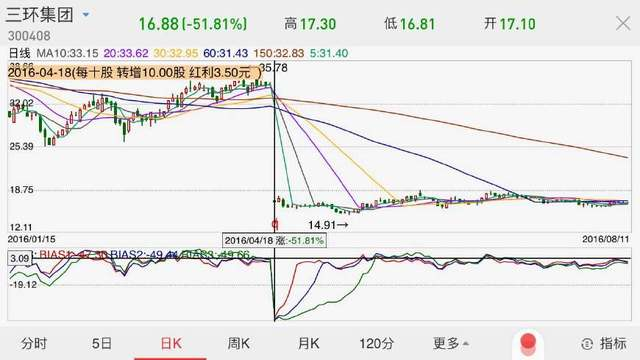

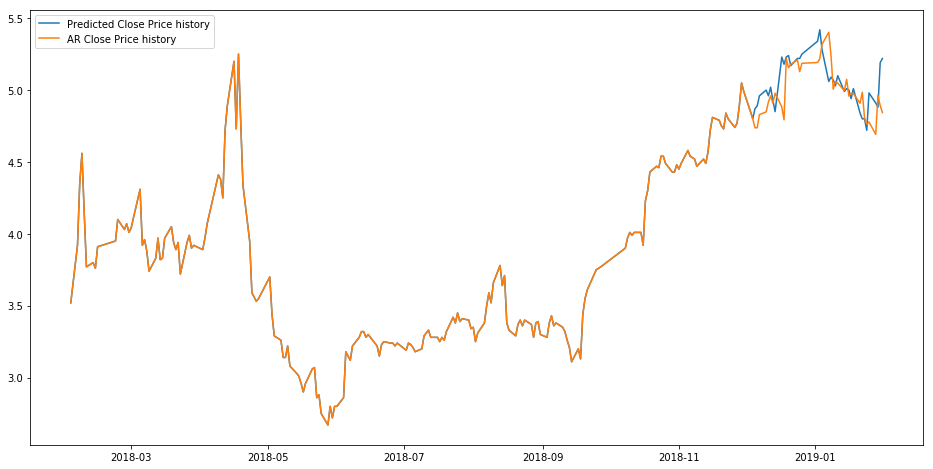

上图中蓝色的部分就是预测值， 关于RNN模型对金融数据的预测，我们只会会增加专门的研讨课程，给大家讲解

我们今天带给大家的是使用RNN进行名字的国籍分类:

## 1. 使用RNN模型进行名字的国籍分类

首先，我们下载数据: 将这个数据置于和我们jupyter notebook位置相同的地方

#### 1.1 我们利用通配符，打印出所有的文件

In [1]:
from io import open
import glob
import os
import matplotlib.pyplot as plt


def find_files(path): return glob.glob(path)

print(find_files('data/names/*.txt'))

['data/names/Czech.txt', 'data/names/German.txt', 'data/names/Arabic.txt', 'data/names/Japanese.txt', 'data/names/Chinese.txt', 'data/names/Vietnamese.txt', 'data/names/Russian.txt', 'data/names/French.txt', 'data/names/Irish.txt', 'data/names/English.txt', 'data/names/Spanish.txt', 'data/names/Greek.txt', 'data/names/Italian.txt', 'data/names/Portuguese.txt', 'data/names/Scottish.txt', 'data/names/Dutch.txt', 'data/names/Korean.txt', 'data/names/Polish.txt']


### 1.2 名字里边包含不少非Ascii码，为了简便问题，我们将他们转化为Ascii码

In [2]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicode_2_Ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicode_2_Ascii('Ślusàrski'))

Slusarski


### Step1.3 然后我们建立类别和对于的名字的dictionary对应

In [3]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def read_lines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicode_2_Ascii(line) for line in lines]

for filename in find_files('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = read_lines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [4]:
n_categories

18

In [5]:
category_lines['Chinese'][:10]

['Ang', 'AuYong', 'Bai', 'Ban', 'Bao', 'Bei', 'Bian', 'Bui', 'Cai', 'Cao']

### 1.4 这一次我们使用pytorch, 来进行向量化

In [6]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letter_to_index(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letter_to_tensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letter_to_index(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letter_to_index(letter)] = 1
    return tensor

print(letter_to_index('J'))

print(line_to_tensor('Jones').size())

35
torch.Size([5, 1, 57])


In [7]:
line_to_tensor('Jones')

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0

我们可以看到，是对名字里的每个字符做了 one-hot操作

### 1.5 然后，我们构建一个这样的RNN网络

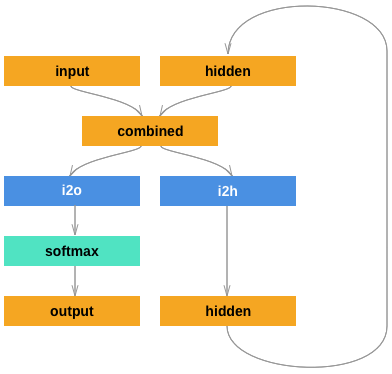

In [8]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128

In [9]:
rnn = RNN(n_letters, n_hidden, n_categories)

### 1.6 运行一步RNN

为了运行这个rnn网络，我们需要给他一个input，然后再加上一个hidden state. 然后我们就能过获得一个output，这个output便是的是这个单词的属于每个国家的概率，和接下来的hidden state.

In [10]:
input = letter_to_tensor('A')
hidden =torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [11]:
output

tensor([[-2.9542, -2.8928, -2.8966, -2.7948, -2.9705, -2.8868, -2.8665, -2.9279,
         -2.8585, -2.8093, -2.8176, -2.8509, -2.9826, -2.9617, -2.9746, -2.8429,
         -2.8799, -2.8882]], grad_fn=<LogSoftmaxBackward>)

In [12]:
next_hidden

tensor([[-0.0408, -0.0133,  0.0868,  0.0108, -0.0454,  0.0005, -0.0878, -0.0240,
         -0.0347, -0.0192, -0.0911, -0.0518,  0.0491, -0.0611, -0.0264,  0.0211,
          0.0268, -0.0671, -0.0008,  0.0141, -0.0089, -0.0619,  0.1341,  0.0173,
          0.0525, -0.0191, -0.0041,  0.0276, -0.0066, -0.0509, -0.0093,  0.0813,
          0.0873, -0.0710,  0.0388, -0.0247,  0.0378,  0.0623, -0.0076,  0.0580,
         -0.0054,  0.0806,  0.0421,  0.0704, -0.0086, -0.0460,  0.0050, -0.0315,
         -0.1039,  0.0580,  0.0703, -0.0331,  0.0098,  0.0549,  0.0443,  0.0395,
          0.0312,  0.0235, -0.0329, -0.0893,  0.0771,  0.0483,  0.1062, -0.0301,
         -0.0621, -0.1345, -0.1102, -0.1147, -0.1013,  0.0269, -0.0390, -0.0686,
         -0.0138, -0.0321,  0.0742, -0.0056,  0.0032,  0.0926, -0.1039,  0.0268,
         -0.0613,  0.0451,  0.0461, -0.0073,  0.0054, -0.0486,  0.0597, -0.0211,
         -0.0548, -0.0281,  0.0043,  0.0098,  0.0856,  0.0122,  0.0288,  0.0330,
          0.0103, -0.0415, -

然后，我们可以使用 line_to_tensor, 把一句话直接变成 tensor

In [13]:
input = line_to_tensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9542, -2.8928, -2.8966, -2.7948, -2.9705, -2.8868, -2.8665, -2.9279,
         -2.8585, -2.8093, -2.8176, -2.8509, -2.9826, -2.9617, -2.9746, -2.8429,
         -2.8799, -2.8882]], grad_fn=<LogSoftmaxBackward>)


这个output，就是基于目前的RNN参数，预测出来的国籍概率分布。显然是不对的，因为里边的参数都是随机的。

### 1.7 更好的观察结果

为了能够更好的看到我们的训练结果，我们需要把输出的tensor变成我们能看懂的国籍

In [14]:
def category_from_output(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i



对于刚刚产生的output，我们使用这个函数

In [15]:
print(category_from_output(output))

('Japanese', 3)


### 1.8 随机生成训练数据

In [16]:
import random

def sample(l):
    return l[random.randint(0, len(l) - 1)]

def sample_trainning():
    category = sample(all_categories)
    line = sample(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = sample_trainning()
    print('category =', category, '/ line =', line)

category = German / line = Kaube
category = Portuguese / line = Ferro
category = Polish / line = Sitko
category = Vietnamese / line = Le
category = Dutch / line = Rompuy
category = Vietnamese / line = Luong
category = Spanish / line = Andreu
category = Arabic / line = Said
category = Scottish / line = Aitken
category = Greek / line = Gravari


### 因为我们这个模型需要 softmax 来获得每个类别，所以我们使用cross-entropy作为Loss函数

In [17]:
criterion = nn.CrossEntropyLoss()

In [18]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [19]:
import time
import math

n_iters = 1000 # 这个数字你可以调大一些
print_every = 500
plot_every = 100


# Keep track of losses for plotting
current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = sample_trainning()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

500 50% (0m 0s) 3.0267 Vlach / German ✗ (Czech)
1000 100% (0m 1s) 2.8804 Mao / Japanese ✗ (Chinese)


### 1.9 观察Loss的变化

In [20]:
all_losses

[2.8747832417488097,
 2.881124267578125,
 2.87689439535141,
 2.8817990684509276,
 2.8642094469070436,
 2.88286892414093,
 2.8674044680595396,
 2.8611317586898806,
 2.8549266815185548,
 2.8391274404525757]

In [21]:
%matplotlib inline

In [22]:
#plt.plot(all_losses)

In [25]:
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(line_to_tensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-2.74) Japanese
(-2.79) Dutch
(-2.80) English

> Jackson
(-2.62) Scottish
(-2.80) English
(-2.81) Chinese

> Satoshi
(-2.77) Japanese
(-2.81) Italian
(-2.82) Russian


## 代码练习

Common

In [5]:
from io import open
import glob
import os
import matplotlib.pyplot as plt
import random
import unicodedata
import string
import torch
import time
import math

import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
import torch

def find_files(path): return glob.glob(path)


all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)


# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicode_2_Ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )


# Build the category_lines dictionary, a list of names per language
# Read a file and split into lines
def read_lines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicode_2_Ascii(line) for line in lines]


def get_languages_and_names() -> (list, dict):
    category_lines = {}
    all_categories = []
    for filename in find_files('data/names/*.txt'):
        category = os.path.splitext(os.path.basename(filename))[0]
        all_categories.append(category)
        lines = read_lines(filename)
        category_lines[category] = lines
    return all_categories, category_lines


# Find letter index from all_letters, e.g. "a" = 0
def letter_to_index(letter):
    return all_letters.find(letter)


# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letter_to_tensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letter_to_index(letter)] = 1
    return tensor


# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letter_to_index(letter)] = 1
    return tensor


def category_from_output(output, all_categories: list):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i


def sample(l):
    return l[random.randint(0, len(l) - 1)]


def sample_training(all_categories: list, category_lines: dict):
    category = sample(all_categories)  # all_categories:所有的国家名 ，category: 某个国家名
    line = sample(category_lines[category])  # line : 某个国家的人的名字
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = line_to_tensor(line)
    line_tensor = pad_sequence(line_tensor)
    return category, line, category_tensor, line_tensor

def sample_training1(all_categories: list, category_lines: dict):
    category = sample(all_categories)  # all_categories:所有的国家名 ，category: 某个国家名
    line = sample(category_lines[category])  # line : 某个国家的人的名字
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor


learning_rate = 0.005  # If you set this too high, it might explode. If too low, it might not learn
input_size = n_letters


def max_name_length(category_lines: dict):
    return len(max(category_lines, key=len))

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def plot_loss(all_losses: list, labels: list):
    for index, each in enumerate(all_losses):
        plt.plot([x for x in range(1, len(each) + 1)], each, label=labels[index])
    plt.legend()
    plt.show()
    return

n_hidden = 128
n_iters = 5000  # 这个数字你可以调大一些
print_every = 1000
plot_every = 100
all_categories, category_lines = get_languages_and_names()
sequence_length = max_name_length(category_lines)

### 1. 尝试在我们的RNN模型中添加更多layers，然后观察Loss变化

1000 20% (0m 2s) 2.9490 Stueck / Russian ✗ (German)
2000 40% (0m 4s) 2.7815 Ramires / Greek ✗ (Portuguese)
3000 60% (0m 7s) 2.8111 Abarca / Czech ✗ (Spanish)
4000 80% (0m 9s) 2.8703 Kolijn / Scottish ✗ (Dutch)
5000 100% (0m 12s) 2.4921 Rusnak / Polish ✓
1000 20% (0m 4s) 2.8319 Maria / Japanese ✗ (Portuguese)
2000 40% (0m 8s) 2.1873 Avgerinos / Greek ✓
3000 60% (0m 12s) 2.8246 Dinh / Korean ✗ (Vietnamese)
4000 80% (0m 16s) 2.7062 Alo / Spanish ✗ (Italian)
5000 100% (0m 20s) 2.4849 Campo / Italian ✓
1000 20% (0m 5s) 2.4541 Vassilikos / Greek ✓
2000 40% (0m 10s) 2.8803 Kappel / Dutch ✗ (German)
3000 60% (0m 16s) 2.7277 Vogt / French ✗ (German)
4000 80% (0m 21s) 2.6914 Murray / Irish ✗ (Scottish)
5000 100% (0m 27s) 2.0508 Dubhain / Irish ✓
1000 20% (0m 7s) 2.8865 Harb / Chinese ✗ (Arabic)
2000 40% (0m 15s) 2.6612 Simpson / Irish ✗ (Scottish)
3000 60% (0m 23s) 2.8214 Karl / Scottish ✗ (German)
4000 80% (0m 31s) 2.6935 Jong / Chinese ✗ (Korean)
5000 100% (0m 38s) 3.0344 Daniau / Vietnamese ✗

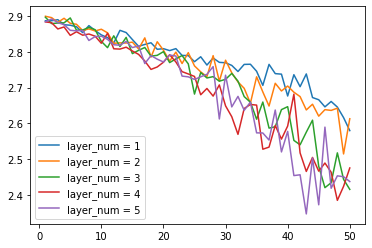

In [6]:
class Multi_Layers_RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, hidden_num):
        super(Multi_Layers_RNN, self).__init__()

        self.hidden_size = hidden_size
        self.hidden_num = hidden_num

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        for i in range(self.hidden_num):
            combined = torch.cat((input, hidden), 1)
            hidden = self.i2h(combined)

        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

def multi_layers_train(category_tensor, line_tensor, rnn: Multi_Layers_RNN, criterion):
    hidden = rnn.initHidden()

    rnn.zero_grad()
    output = None
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)  # 第i个字母的tensor
    # 将所有的输入传入后，最后得到的输出，来比较loss
    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

    
def muti_layers_training(all_categories: list, category_lines: dict, rnn):
    start = time.time()
    current_loss = 0
    all_losses = []
    criterion = nn.CrossEntropyLoss()

    for iter in range(1, n_iters + 1):
        category, line, category_tensor, line_tensor = sample_training1(all_categories, category_lines)
        output, loss = multi_layers_train(category_tensor, line_tensor, rnn, criterion)
        current_loss += loss

        if iter % print_every == 0:
            guess, guess_i = category_from_output(output, all_categories)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('%d %d%% (%s) %.4f %s / %s %s' % (
            iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

        # Add current loss avg to list of losses
        if iter % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            current_loss = 0      

    return all_losses
  

def multi_layers_model():
    hidden_num = 5
    all_losses = []
    labels = []
    for layer_num in range(0, hidden_num):
        rnn_multi_layers = Multi_Layers_RNN(n_letters, n_hidden, len(all_categories), layer_num + 1)
        losses = muti_layers_training(all_categories, category_lines, rnn_multi_layers)
        all_losses.append(losses)
        labels.append('layer_num = ' + str(layer_num + 1))
    plot_loss(all_losses, labels)
    return

multi_layers_model()

### 2. 将原始的RNN模型改成nn.LSTM和nn.GRU， 并且改变 `n_iters = 1000 ` 这个值，观察其变化

1000 100% (0m 7s) 1.5591 Paterson / Scottish ✓
1000 100% (0m 6s) 1.2072 Yun / Vietnamese ✗ (Korean)
1000 20% (0m 7s) 2.4388 Zogby / Czech ✗ (Arabic)
2000 40% (0m 13s) 1.0629 Gil / Korean ✓
3000 60% (0m 20s) 2.5362 Hyde / Korean ✗ (English)
4000 80% (0m 27s) 0.8279 Paquet / French ✓
5000 100% (0m 34s) 2.2427 Pledger / German ✗ (English)
1000 20% (0m 6s) 1.7066 Sartre / German ✗ (French)
2000 40% (0m 12s) 3.5445 Fabel / English ✗ (German)
3000 60% (0m 19s) 1.0606 Cucinotta / Italian ✓
4000 80% (0m 25s) 0.2890 Deschamps / French ✓
5000 100% (0m 32s) 1.2985 Redden / Dutch ✗ (English)


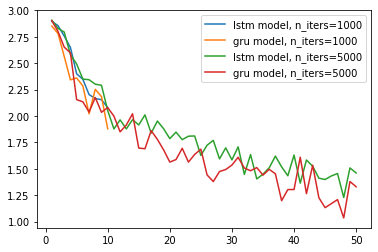

In [8]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)  # LSTM
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        out = self.softmax(out)
        return out


class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)  # GRU
        self.fc = nn.Linear(hidden_size, num_classes)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        out = self.softmax(out)
        return out

def lstm_gru_train(category_tensor, line_tensor, rnn: LSTM, criterion, optimizer):
    output = rnn(line_tensor)
    loss = criterion(output, category_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return output, loss.item()


def training(all_categories: list, category_lines: dict, rnn, n_iters):
    start = time.time()
    current_loss = 0
    all_losses = []
    criterion = nn.CrossEntropyLoss()
    # criterion = nn.NLLLoss()

    optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

    for iter in range(1, n_iters + 1):
        category, line, category_tensor, line_tensor = sample_training(all_categories, category_lines)
        output, loss = lstm_gru_train(category_tensor, line_tensor, rnn, criterion, optimizer)
        current_loss += loss

        # Print iter number, loss, name and guess
        if iter % print_every == 0:
            guess, guess_i = category_from_output(output, all_categories)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('%d %d%% (%s) %.4f %s / %s %s' % (
                iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

        # Add current loss avg to list of losses
        if iter % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            current_loss = 0
    return all_losses


def diff_model_train():
    all_losses = []
    labels = []
    n_iters = 1000
    rnn_lstm = LSTM(n_letters, n_hidden, 1, len(all_categories))
    losses = training(all_categories, category_lines, rnn_lstm, n_iters)
    all_losses.append(losses)
    labels.append('lstm model, n_iters=1000')

    gru_lstm = GRU(n_letters, n_hidden, 1, len(all_categories))
    losses = training(all_categories, category_lines, gru_lstm, n_iters)
    all_losses.append(losses)
    labels.append('gru model, n_iters=1000')

    n_iters = 5000
    rnn_lstm = LSTM(n_letters, n_hidden, 1, len(all_categories))
    losses = training(all_categories, category_lines, rnn_lstm, n_iters)
    all_losses.append(losses)
    labels.append('lstm model, n_iters=5000')

    gru_lstm = GRU(n_letters, n_hidden, 1, len(all_categories))
    losses = training(all_categories, category_lines, gru_lstm, n_iters)
    all_losses.append(losses)
    labels.append('gru model, n_iters=5000')
    
    plot_loss(all_losses, labels)
    
diff_model_train()

### 3. 把该RNN模型变成多层RNN模型，观察Loss的变化

1000 100% (0m 6s) 2.0781 Hassel / Dutch ✓
1000 100% (0m 11s) 1.5281 Ha / Chinese ✗ (Korean)
1000 100% (0m 17s) 2.8731 Vuong / English ✗ (Vietnamese)
1000 100% (0m 6s) 1.0478 Kasaya / Japanese ✓
1000 100% (0m 11s) 2.8670 Nenci / Portuguese ✗ (Italian)
1000 100% (0m 16s) 2.9392 Awlukoff / Spanish ✗ (Russian)


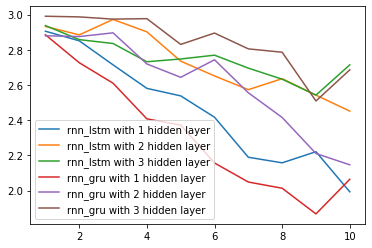

In [10]:
def diff_model_diff_layers():
    all_losses = []
    labels = []
    n_iters = 1000
    rnn_lstm_1 = LSTM(n_letters, n_hidden, 1, len(all_categories))
    rnn_lstm_2 = LSTM(n_letters, n_hidden, 2, len(all_categories))
    rnn_lstm_3 = LSTM(n_letters, n_hidden, 3, len(all_categories))

    all_losses_1 = training(all_categories, category_lines, rnn_lstm_1, n_iters)
    all_losses.append(all_losses_1)
    labels.append('rnn_lstm with 1 hidden layer')
    all_losses_2 = training(all_categories, category_lines, rnn_lstm_2, n_iters)
    all_losses.append(all_losses_2)
    labels.append('rnn_lstm with 2 hidden layer')
    all_losses_3 = training(all_categories, category_lines, rnn_lstm_3, n_iters)
    all_losses.append(all_losses_3)
    labels.append('rnn_lstm with 3 hidden layer')

    gru_1 = GRU(n_letters, n_hidden, 1, len(all_categories))
    gru_2 = GRU(n_letters, n_hidden, 2, len(all_categories))
    gru_3 = GRU(n_letters, n_hidden, 3, len(all_categories))
    all_losses_1 = training(all_categories, category_lines, gru_1, n_iters)
    all_losses.append(all_losses_1)
    labels.append('rnn_gru with 1 hidden layer')
    all_losses_2 = training(all_categories, category_lines, gru_2, n_iters)
    all_losses.append(all_losses_2)
    labels.append('rnn_gru with 2 hidden layer')
    all_losses_3 = training(all_categories, category_lines, gru_3, n_iters)
    all_losses.append(all_losses_3)
    labels.append('rnn_gru with 3 hidden layer')
    plot_loss(all_losses, labels)
    
diff_model_diff_layers()

### 4. Pytorch里边常用nn.NLLoss来代替crossentropy，将criterion改为nn.NLLoss，观察变化

1000 100% (0m 6s) 1.7068 Cunningham / French ✗ (Scottish)
1000 100% (0m 6s) 2.2897 Porras / Greek ✗ (Spanish)


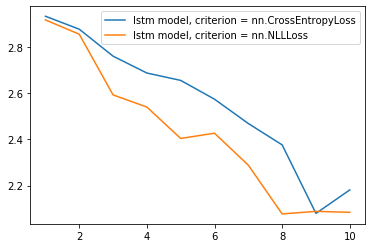

In [13]:
def training2(all_categories: list, category_lines: dict, rnn, n_iters):
    start = time.time()
    current_loss = 0
    all_losses = []
    criterion = nn.NLLLoss()

    optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

    for iter in range(1, n_iters + 1):
        category, line, category_tensor, line_tensor = sample_training(all_categories, category_lines)
        output, loss = lstm_gru_train(category_tensor, line_tensor, rnn, criterion, optimizer)
        current_loss += loss

        # Print iter number, loss, name and guess
        if iter % print_every == 0:
            guess, guess_i = category_from_output(output, all_categories)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('%d %d%% (%s) %.4f %s / %s %s' % (
                iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

        # Add current loss avg to list of losses
        if iter % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            current_loss = 0
    return all_losses

def train_diff_loss():
    all_losses = []
    labels = []
    n_iters = 1000
    rnn_lstm_1 = LSTM(n_letters, n_hidden, 1, len(all_categories))
    losses = training(all_categories, category_lines, rnn_lstm_1, n_iters)
    all_losses.append(losses)
    labels.append('lstm model, criterion = nn.CrossEntropyLoss')

    rnn_lstm_2 = LSTM(n_letters, n_hidden, 1, len(all_categories))
    losses = training2(all_categories, category_lines, rnn_lstm_2, n_iters)
    all_losses.append(losses)
    labels.append('lstm model, criterion = nn.NLLLoss')

    plot_loss(all_losses, labels)
    

train_diff_loss()
